# Import Library

In [1]:
import tensorflow as tf
import numpy as np
import warnings
from PIL import Image
import IPython.display as display
import random
from numpy.random import choice
import matplotlib.pyplot as plt, zipfile
import xml.etree.ElementTree as ET
import time
import xml.dom.minidom
from IPython.display import FileLink, FileLinks
import os, glob

['all', 'Annotation']


# Hyperparameters

In [3]:
ROOT = './input/'

IMAGES = os.listdir(ROOT + 'all')
breeds = os.listdir(ROOT + 'virus_types/') 

BUFFER_SIZE = 2000
BATCH_SIZE = 8

WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

dim = 256

EPOCHS = 20000
noise_dim = 100
num_examples_to_generate = 16

nm=23

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Data Preprocess

In [4]:
idxIn = 0; namesIn = [] # List of condition
imagesIn = np.zeros((nm,256,256,3)) # Get Images in A Array

for virus in virus_types:
    # iterate through each file in the directory
    for i in os.listdir(ROOT+'virus_types/'+virus):
        try: img = Image.open(ROOT+'all/'+i+'.jpg') 
        except: continue              
        tree = ET.parse(ROOT+'virus_types/'+virus+'/'+i)
        root = tree.getroot()
        objects = root.findall('object')
        # get image & condition
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.resize((256,256), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(virus)
            idxIn += 1
            #print(idxIn)

In [24]:
# check
path = './results/check.txt' 
f = open(path, 'w')
f.write(str(imagesIn.shape[0])+'\n')
f.write(str(imagesIn.shape[1])+'\n')
f.write(str(imagesIn.shape[2])+'\n')
f.write(namesIn[0])
f.close()

In [6]:
# dimension review
print("imagesIn is a {} with {} {} by {} rgb({}) images. Shape: {}".format(type(imagesIn), imagesIn.shape[0], imagesIn.shape[1], imagesIn.shape[2], imagesIn.shape[3], imagesIn.shape))

imagesIn is a <class 'numpy.ndarray'> with 23 256 by 256 rgb(3) images. Shape: (23, 256, 256, 3)


# Data Exploration

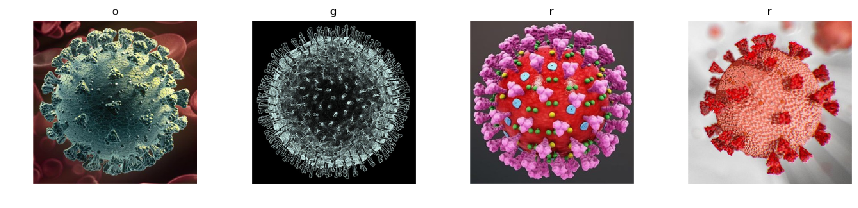

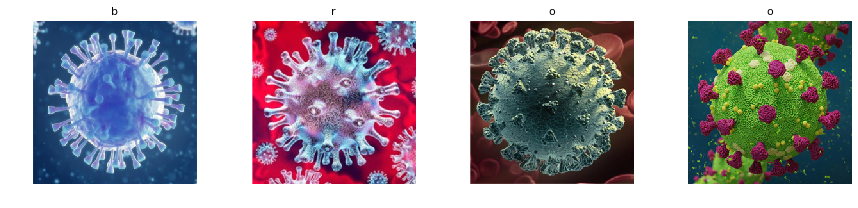

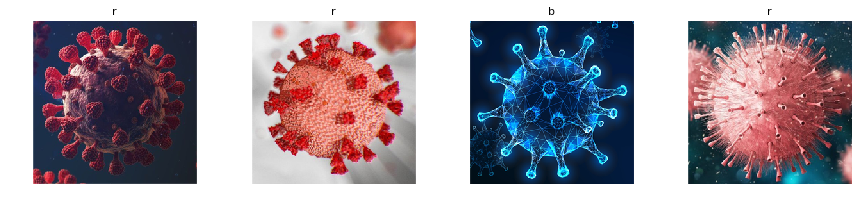

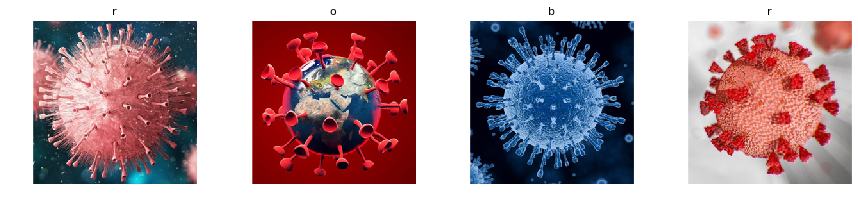

In [6]:
x = np.random.randint(0,idxIn,23)

for k in range(4):
    plt.figure(figsize=(15,3))
    for j in range(4):
        plt.subplot(1,4,j+1)
        #print(k*4+j)
        img = Image.fromarray(imagesIn[x[k*4+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*4+j]],fontsize=11)
        plt.imshow(img)
    plt.show()

# Normalization

In [7]:
# Normalization
imagesIn = (imagesIn[:idxIn,:,:,:]-127.5)/127.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


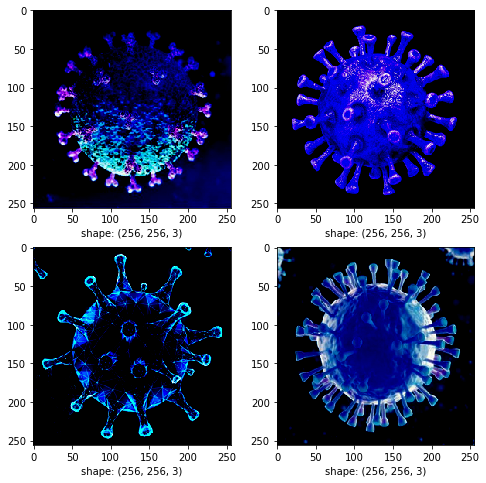

In [8]:
plt.figure(figsize=(8,8))
for image in range(4):
    plt.subplot(2,2, image+1)
    plt.imshow((imagesIn[image]))
    plt.xlabel('shape: {}'.format(imagesIn[image].shape))

# Create Dataset

In [9]:
# Change Datatype from float64 to float32 for TF's gradient descent
imagesIn = tf.cast(imagesIn, 'float32')

In [10]:
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator Model

In [11]:
# function will return a generator model
def make_generator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(32*32*512, use_bias=False, input_shape=(100,)),
            # Normalize the activations of the previous layer at each batch
            tf.keras.layers.BatchNormalization(),
            # apply leaky relu activation: f(x) = {x if x > 0 : 0.01*x}
            tf.keras.layers.LeakyReLU(),
            # reshape input to (32,32,512)
            tf.keras.layers.Reshape((32, 32, 512)),
            
            # second layer Conv2DTranspose
            tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Dense(3,activation='tanh', use_bias=False,\
                kernel_initializer=WEIGHT_INIT)
        ]
    )
    return model

In [12]:
# generator model review
generator = make_generator()
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 524288)            52428800  
_________________________________________________________________
batch_normalization (BatchNo (None, 524288)            2097152   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 524288)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 256)       0

# Random Noise Vector Input

In [13]:
# random noise vector
noise = tf.random.normal([1,100])
# run the generator model with the noise vector as input
generated_image = generator(noise, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


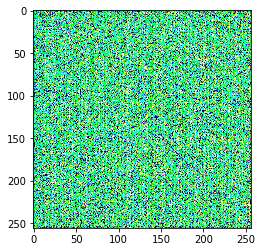

In [14]:
# display 
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

# Discriminator model
We are initializing weights in the first layer with standard deviation = WEIGHT_INIT_STDDEV which will be changing while optimizing for better performance.

In [15]:
def make_discriminator():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[dim,dim,3],\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',\
                kernel_initializer=WEIGHT_INIT),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dropout(0.25),
            
            # flatten input into 1-D and output a single a number from the last layer using sigmoid activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

discriminator = make_discriminator()
print(discriminator.summary())
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)      

# Loss Function and Optimizers
## Label Smoothing
Instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class and [0.0, 0.3] for negative class

In [27]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.5

## Introduce Some Noise
Recomended to introduce some noise to the labels, so out of 1000 real labels, approximately 50 should be flipped to 0 (5%) randomly flip some labels

In [ ]:
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0].value)
    # choose labels to flip
    flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)
    # invert the labels in place
    y[flip_ix] = 1 - y[flip_ix]
    return y

## Loss Function
tf.ones_like changes all values in the tensor to 1s similarly tf.zeros_like changes all values in the tensor to 0 then apply label smoothing

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    real_output_noisy = noisy_labels(real_output_smooth, 0.05)
    
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
    fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function
def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    fake_output_noisy = noisy_labels(fake_output_smooth, 0.05)
    return cross_entropy(fake_output_smooth, fake_output)

## Optimizers

In [ ]:
# optimizers -- Adam
generator_optimizer = tf.optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0002)

# Training Function
Tensorflow "records" all the operations executed inside the context of a tf.GradientTape onto to a "tape". Using that "tape" and the gradients associated with recorded operation, tensorflow computes the gradients of a "recorded" computation using reverse mode differentiaion.

In [18]:
# code from tf dcgan tutorial
def train_step(images, G_loss_list, D_loss_list):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Automatic Differentiation Function
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # the following are the operations recorded onto the "tape"
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    G_loss_list.append(gen_loss.numpy())
    D_loss_list.append(disc_loss.numpy())
    # the following lines are taking the derivatives and applying gradients using Adam optimizer
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)
            
        plot_loss(G_loss, D_loss, epoch)
        G_loss = []
        D_loss = []
        if (epoch % 1000 == 0):
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
            
    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
import time
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)    
    fig = plt.figure(figsize=(8,8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1.)/2.)
        plt.axis('off')
    plt.show()

In [21]:
# plot loss at eatch epoch
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch+1))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Training Results

### Dim: 256, Epochs: 20000

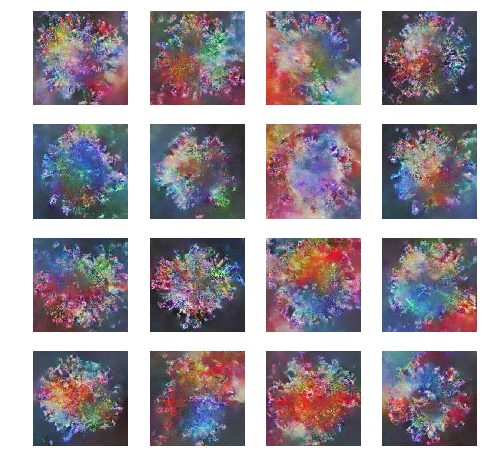

Time for epoch 7901 is 1.7901105880737305 sec


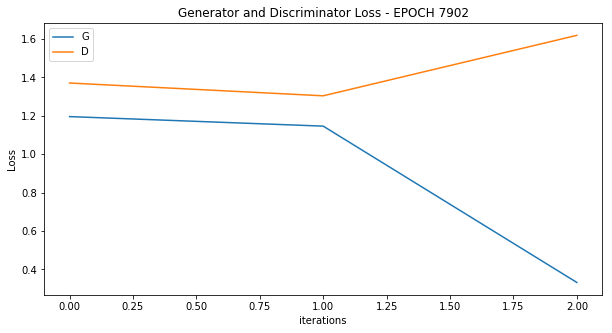

Time for epoch 7902 is 1.0257859230041504 sec


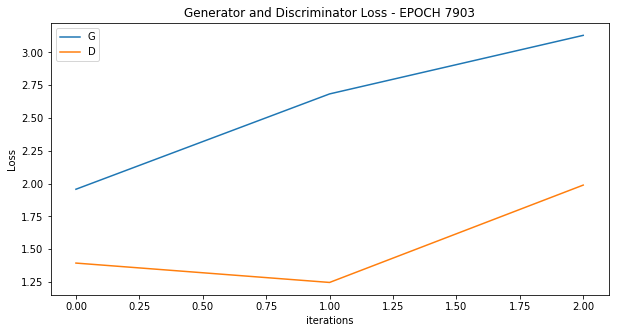

Time for epoch 7903 is 1.0261669158935547 sec


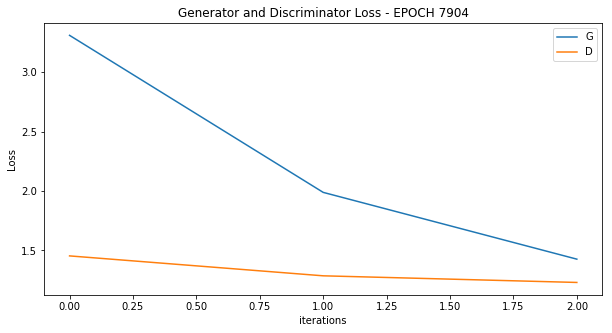

Time for epoch 7904 is 1.0032932758331299 sec


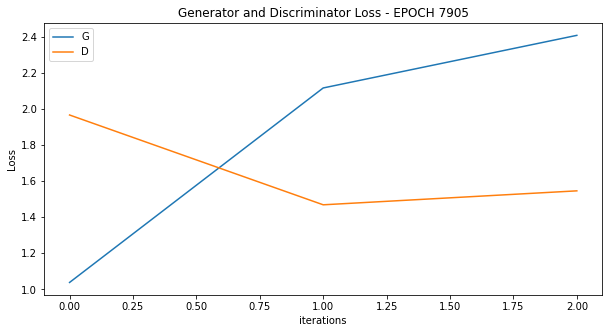

Time for epoch 7905 is 1.0273849964141846 sec


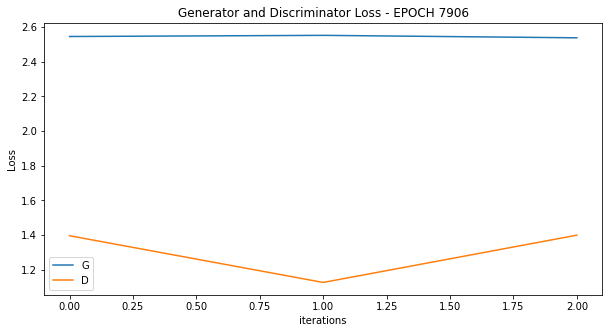

Time for epoch 7906 is 1.0232694149017334 sec


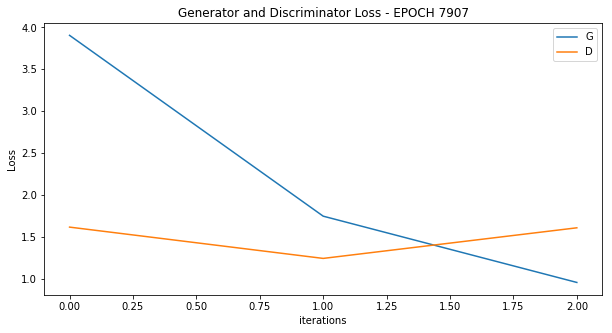

Time for epoch 7907 is 1.0140635967254639 sec


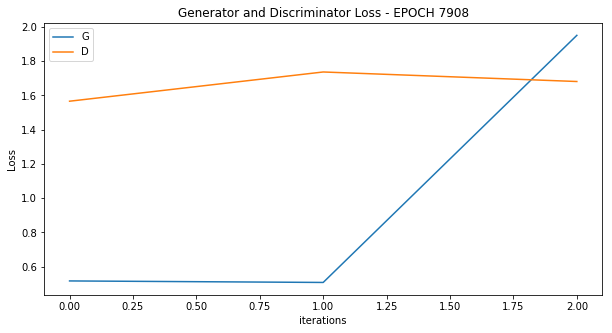

Time for epoch 7908 is 1.0162010192871094 sec


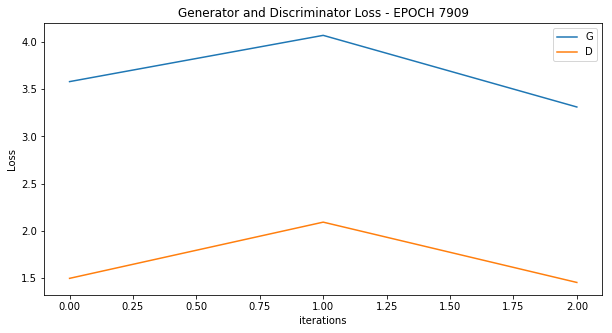

Time for epoch 7909 is 1.0188536643981934 sec


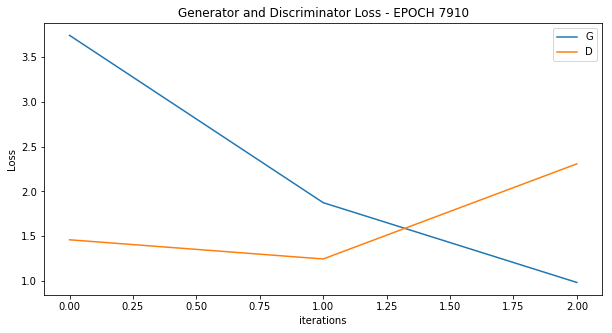

Time for epoch 7910 is 1.0164039134979248 sec


In [ ]:
%%time
BUFFER_SIZE = 20000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 20000
print('Starting training')
train(ds, EPOCHS)

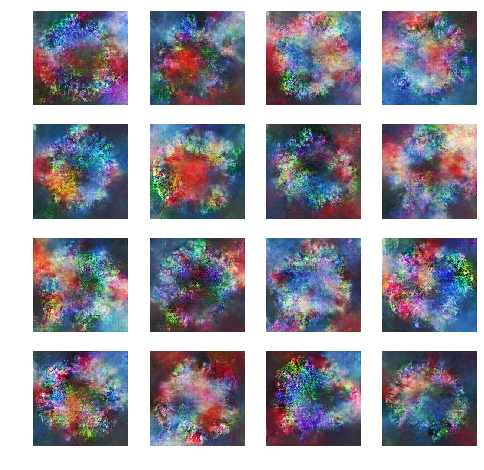

Time for epoch 1991 is 1.60585355758667 sec


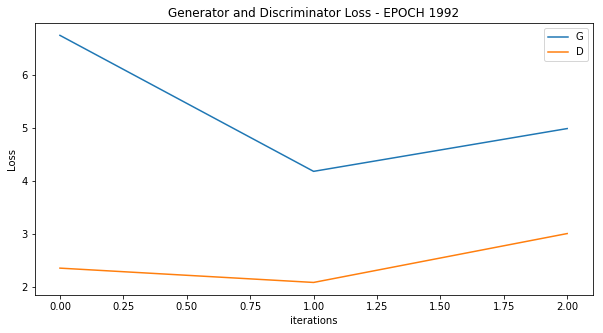

Time for epoch 1992 is 0.9836359024047852 sec


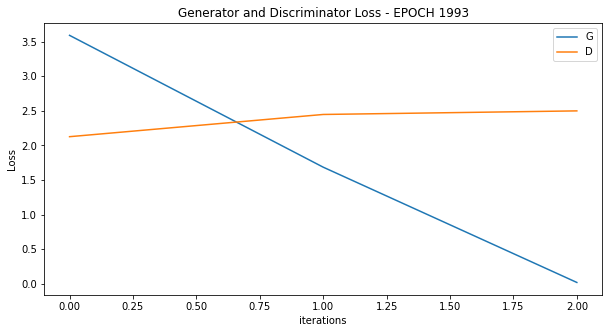

Time for epoch 1993 is 0.9922401905059814 sec


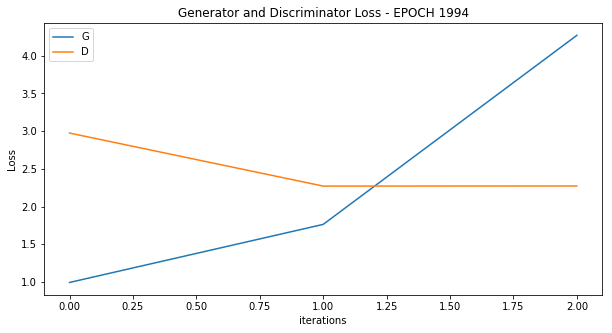

Time for epoch 1994 is 1.1055033206939697 sec


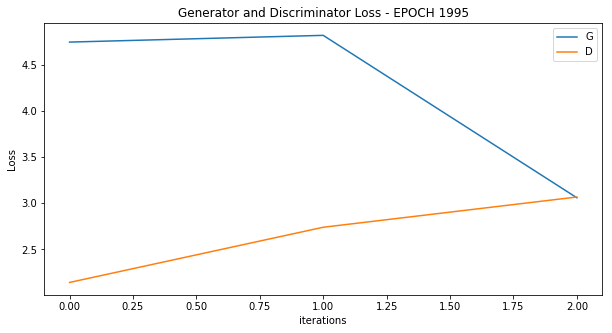

Time for epoch 1995 is 0.9863710403442383 sec


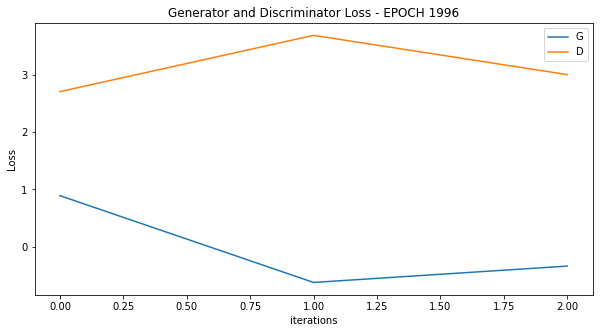

Time for epoch 1996 is 0.9811122417449951 sec


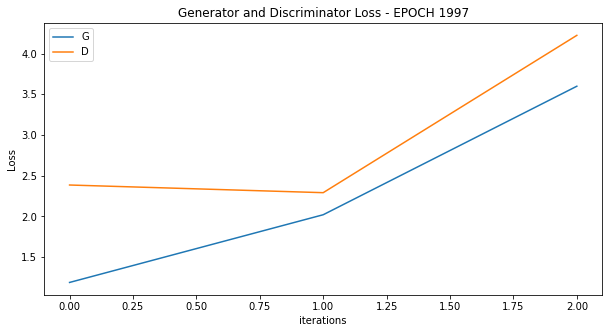

Time for epoch 1997 is 0.9897110462188721 sec


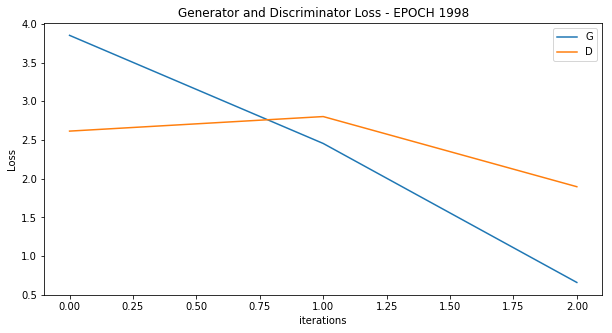

Time for epoch 1998 is 0.9841949939727783 sec


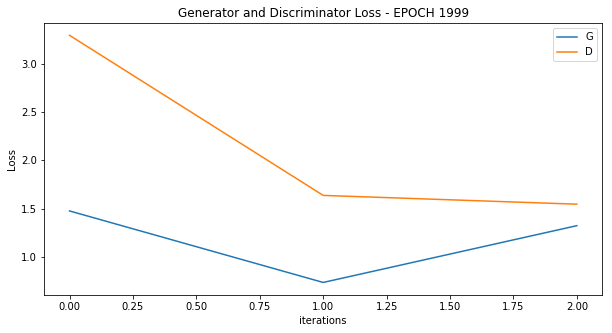

Time for epoch 1999 is 0.9826083183288574 sec


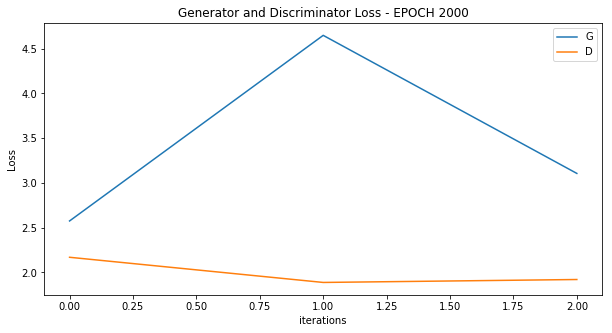

Time for epoch 2000 is 0.9890215396881104 sec
Final Epoch


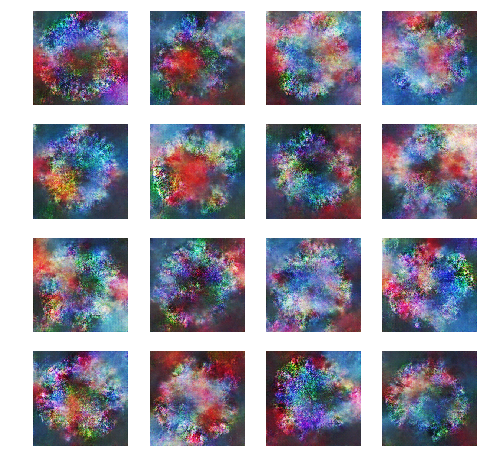

CPU times: user 21min 2s, sys: 13min 55s, total: 34min 58s
Wall time: 35min 22s


In [22]:
%%time
BUFFER_SIZE = 2000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 2000
print('Starting training')
train(ds, EPOCHS)

### Dim: 256, Epochs: 20000

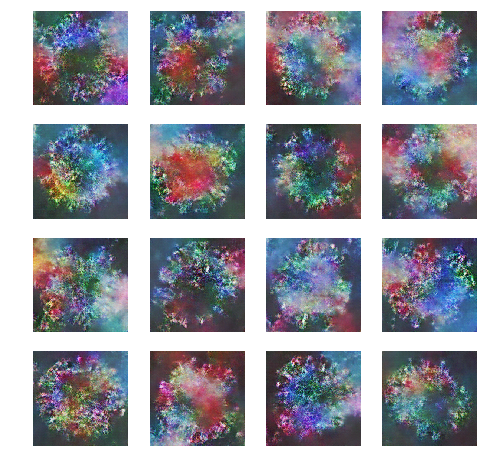

Time for epoch 2001 is 1.6602022647857666 sec


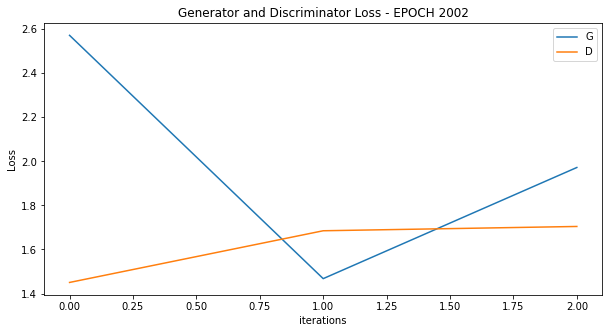

Time for epoch 2002 is 1.0193414688110352 sec


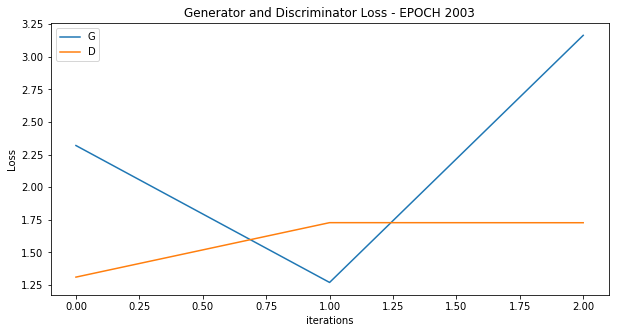

Time for epoch 2003 is 1.0290563106536865 sec


In [ ]:
%%time
BUFFER_SIZE = 20000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 20000
print('Starting training')
train(ds, EPOCHS)

### Dim: 128, Epochs: 2000

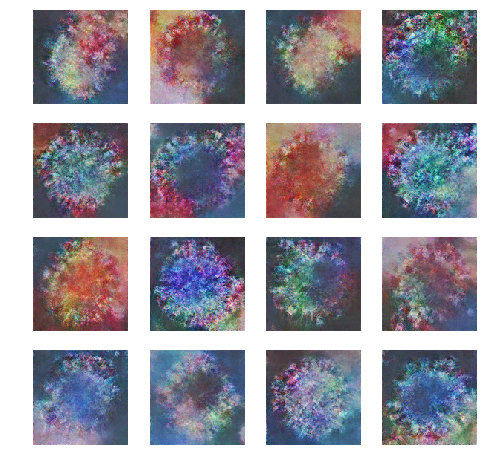

Time for epoch 1991 is 3.0515143871307373 sec


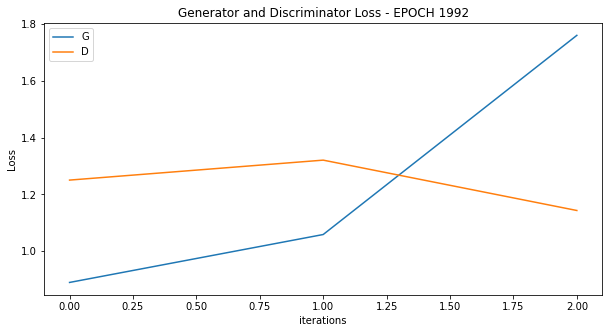

Time for epoch 1992 is 2.4870874881744385 sec


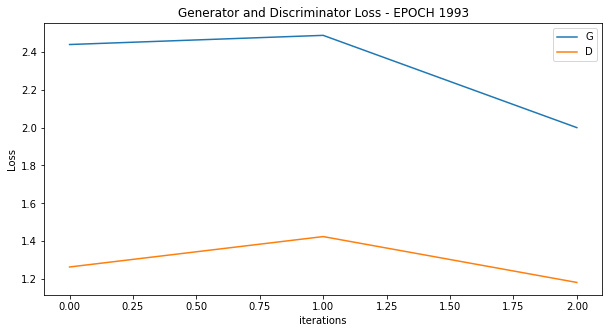

Time for epoch 1993 is 2.487806558609009 sec


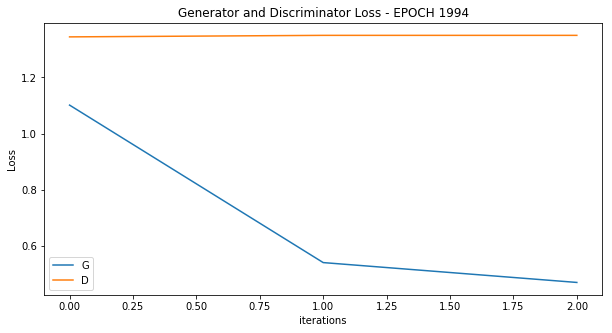

Time for epoch 1994 is 2.4811153411865234 sec


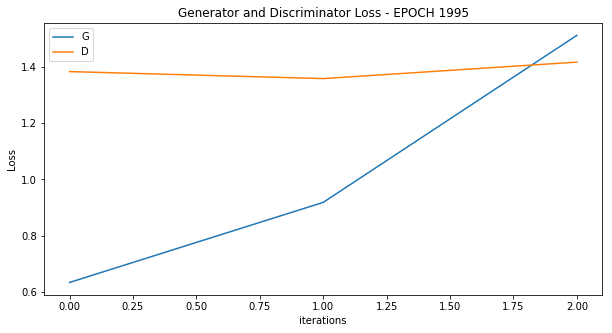

Time for epoch 1995 is 2.486333131790161 sec


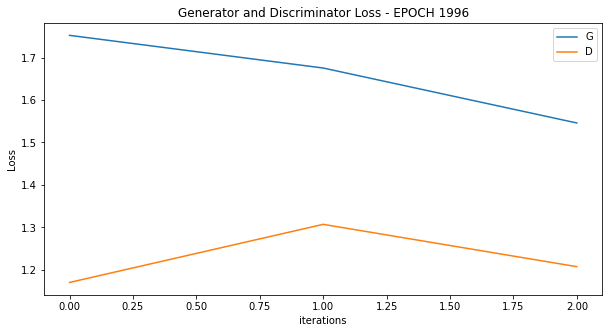

Time for epoch 1996 is 2.4865307807922363 sec


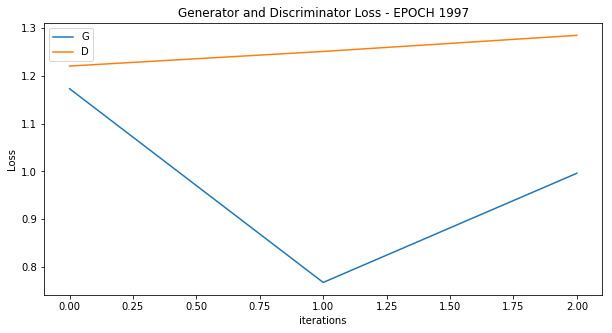

Time for epoch 1997 is 2.6420211791992188 sec


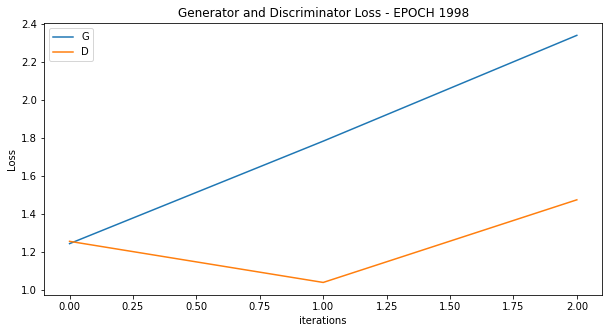

Time for epoch 1998 is 2.4896790981292725 sec


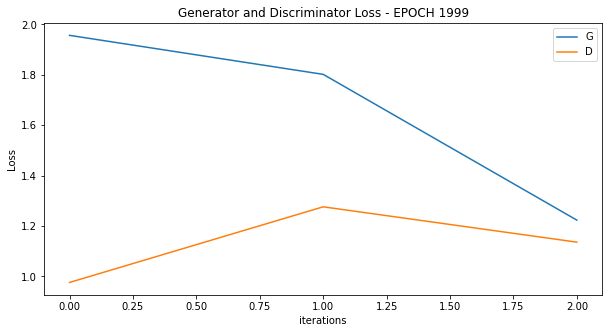

Time for epoch 1999 is 2.485020160675049 sec


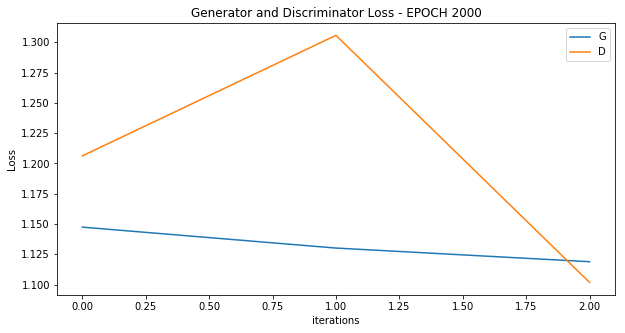

Time for epoch 2000 is 2.493914842605591 sec
Final Epoch


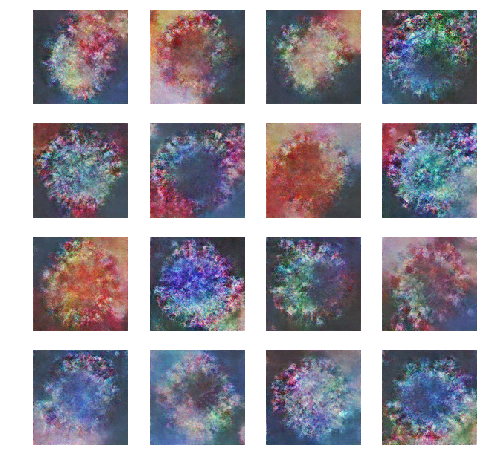

CPU times: user 23min 59s, sys: 13min 30s, total: 37min 29s
Wall time: 1h 25min 10s


In [25]:
%%time
BUFFER_SIZE = 2000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 2000
print('Starting training')
train(ds, EPOCHS)

### Dim: 128, Epochs: 4000

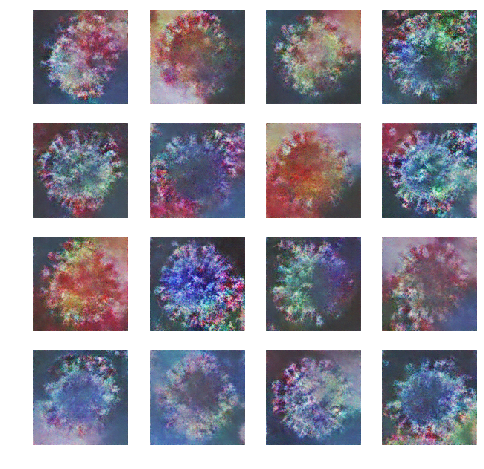

Time for epoch 1361 is 3.039229393005371 sec


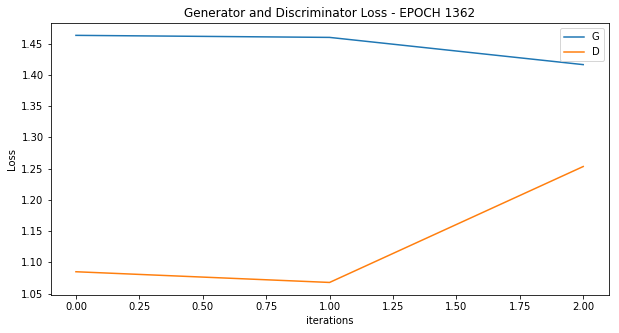

Time for epoch 1362 is 2.490959882736206 sec


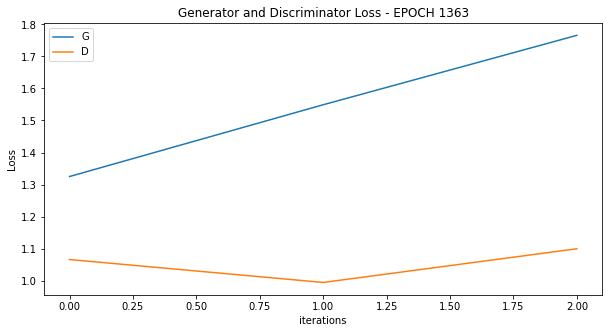

Time for epoch 1363 is 2.4967920780181885 sec


In [ ]:
%%time
BUFFER_SIZE = 4000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 2000
print('Starting training')
train(ds, EPOCHS)

### Dim: 64, Epochs: 2000

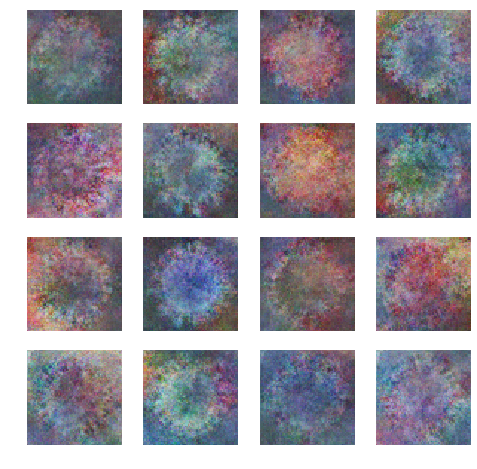

Time for epoch 1991 is 0.8244013786315918 sec


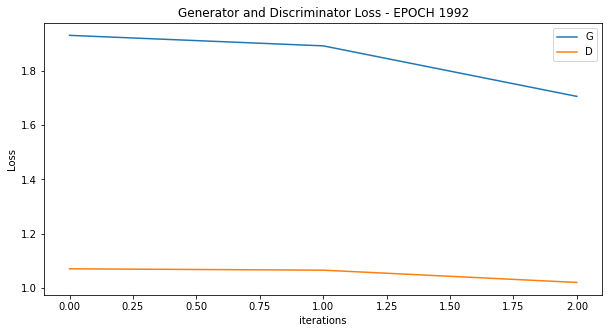

Time for epoch 1992 is 0.30740857124328613 sec


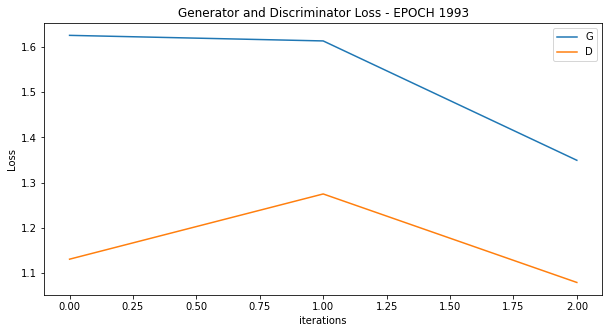

Time for epoch 1993 is 0.28834033012390137 sec


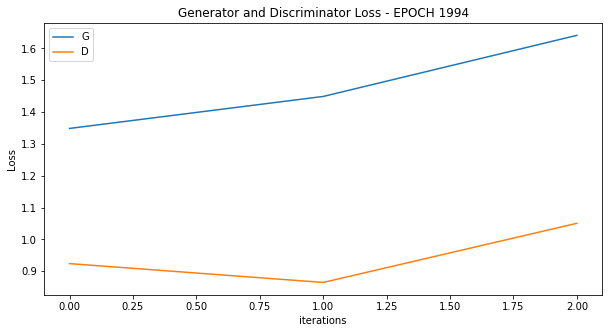

Time for epoch 1994 is 0.29805564880371094 sec


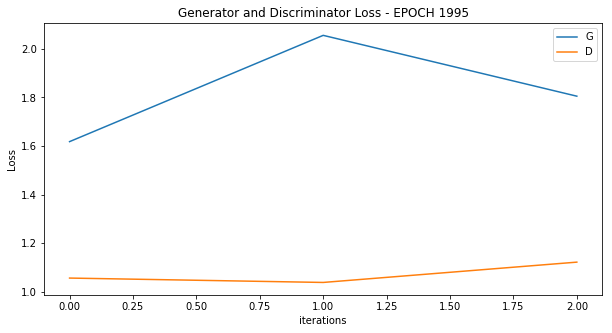

Time for epoch 1995 is 0.28662705421447754 sec


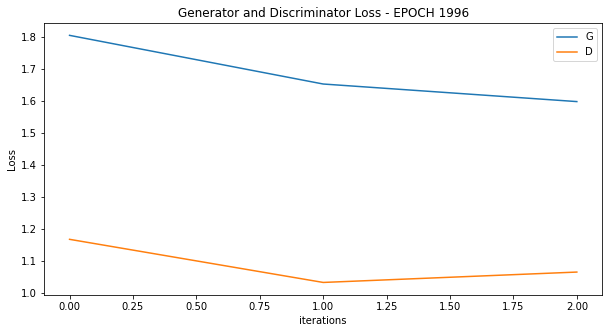

Time for epoch 1996 is 0.29217958450317383 sec


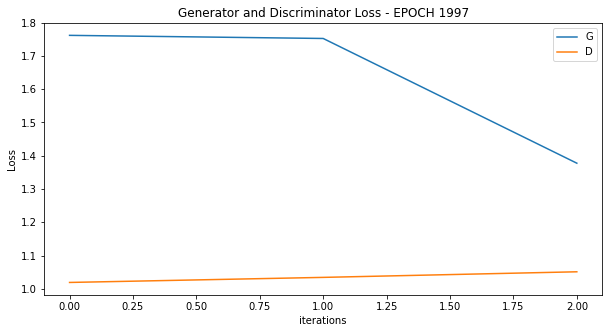

Time for epoch 1997 is 0.301898717880249 sec


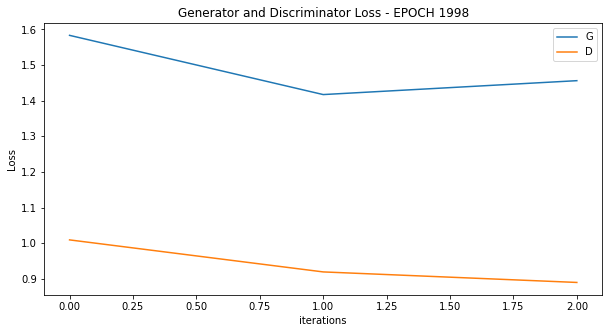

Time for epoch 1998 is 0.3934757709503174 sec


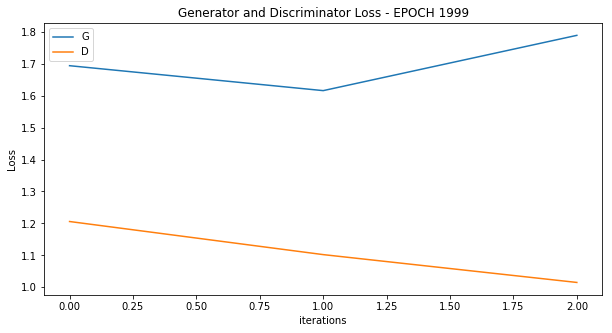

Time for epoch 1999 is 0.30202484130859375 sec


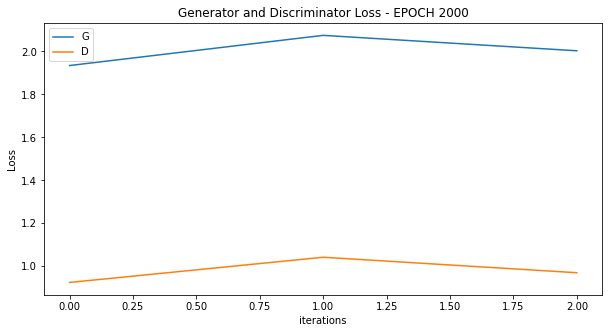

Time for epoch 2000 is 0.29398488998413086 sec
Final Epoch


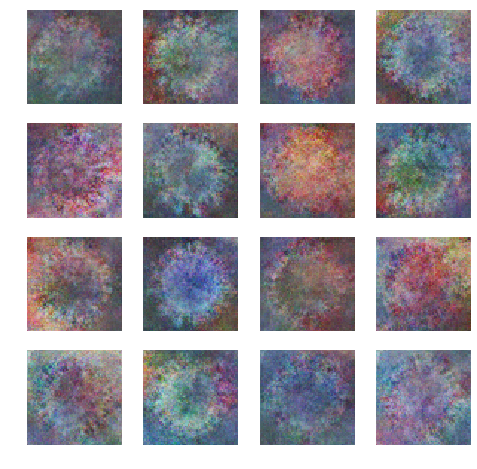

CPU times: user 13min 31s, sys: 10min 5s, total: 23min 36s
Wall time: 11min 53s


In [27]:
%%time
BUFFER_SIZE = 2000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 2000
print('Starting training')
train(ds, EPOCHS)

### Dim: 64, Epochs: 12000

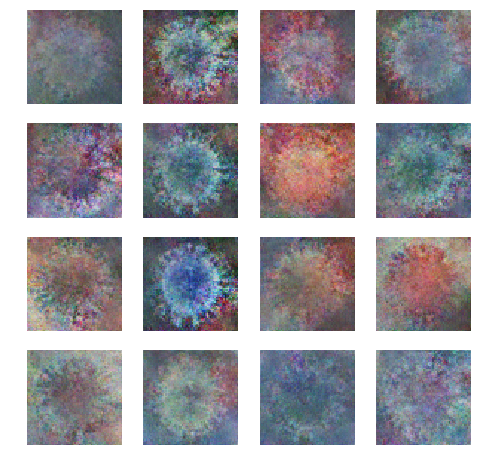

Time for epoch 9991 is 0.8286848068237305 sec


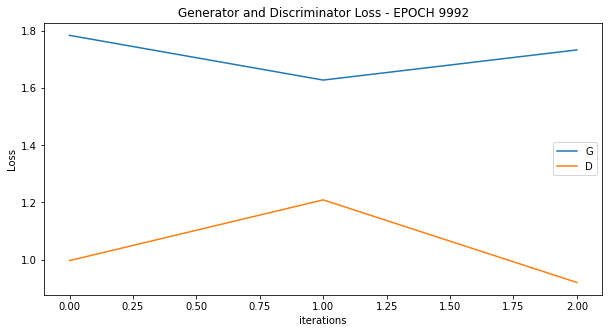

Time for epoch 9992 is 0.29268741607666016 sec


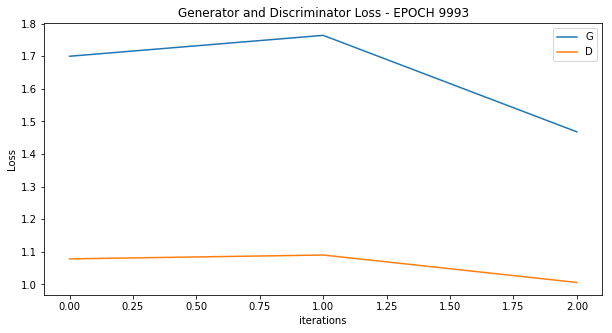

Time for epoch 9993 is 0.29857778549194336 sec


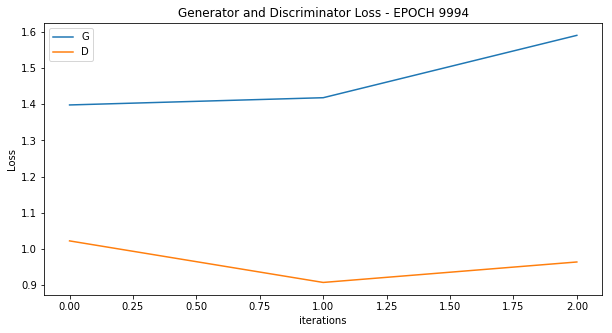

Time for epoch 9994 is 0.3913156986236572 sec


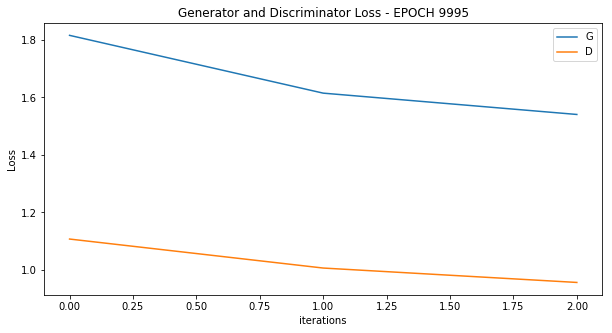

Time for epoch 9995 is 0.288158655166626 sec


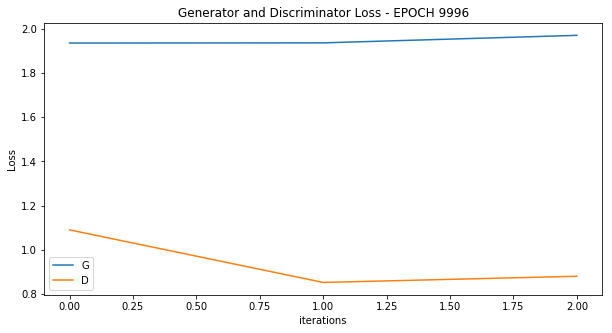

Time for epoch 9996 is 0.29128384590148926 sec


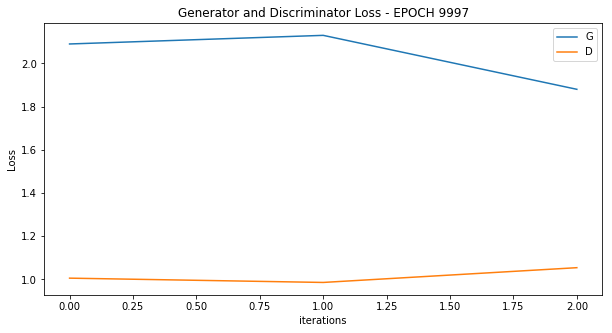

Time for epoch 9997 is 0.2913684844970703 sec


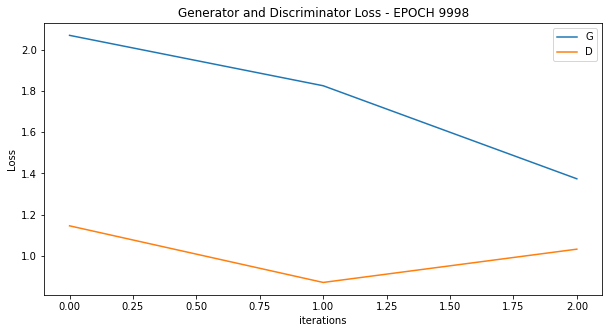

Time for epoch 9998 is 0.29108142852783203 sec


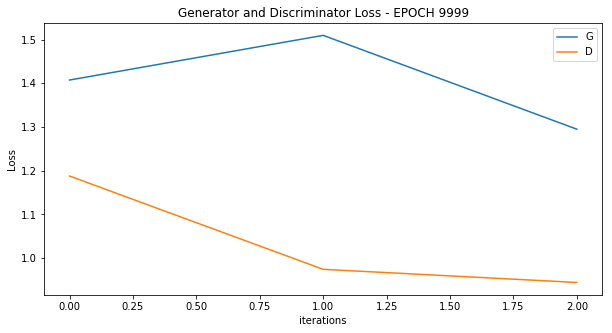

Time for epoch 9999 is 0.28880906105041504 sec


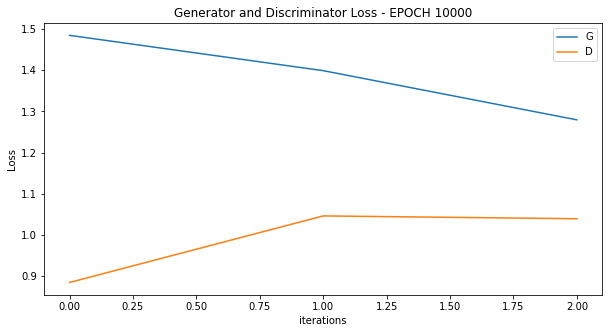

Time for epoch 10000 is 0.2934892177581787 sec
Final Epoch


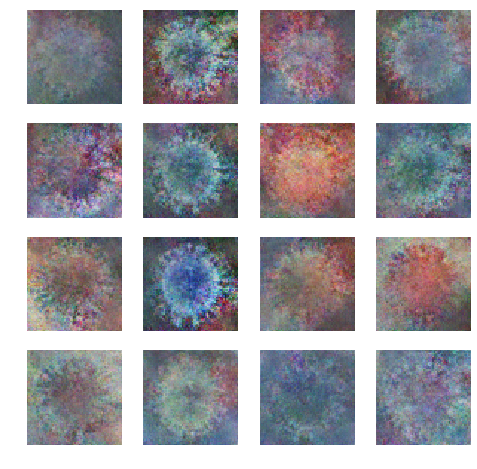

CPU times: user 1h 7min 43s, sys: 51min 6s, total: 1h 58min 49s
Wall time: 59min 33s


In [29]:
%%time
BUFFER_SIZE = 2000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 10000
print('Starting training')
train(ds, EPOCHS)

### Dim: 64, Epochs: 52000

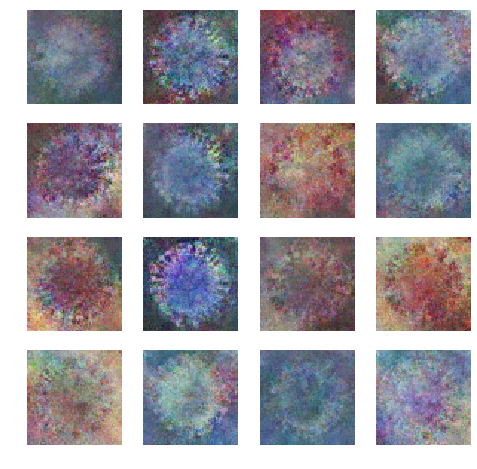

Time for epoch 8741 is 0.8391509056091309 sec


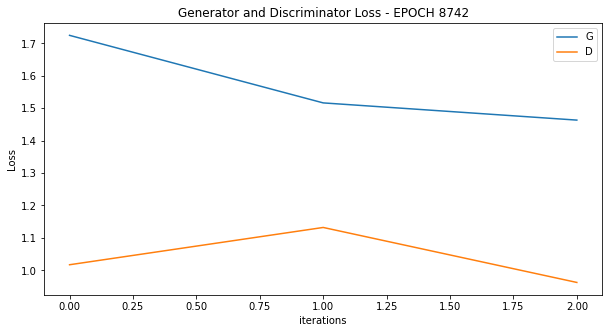

Time for epoch 8742 is 0.2955491542816162 sec


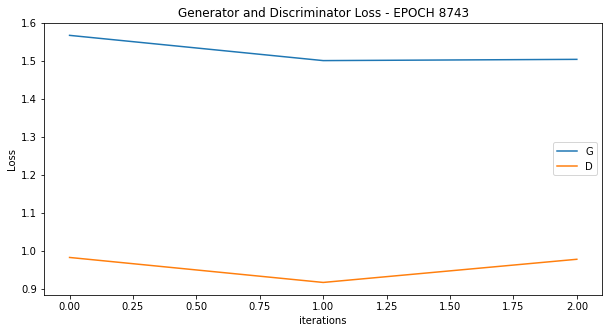

Time for epoch 8743 is 0.3049964904785156 sec


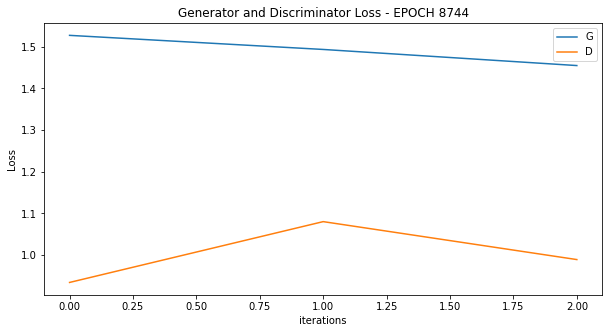

Time for epoch 8744 is 0.2852189540863037 sec


Time for epoch 8745 is 0.297229528427124 sec


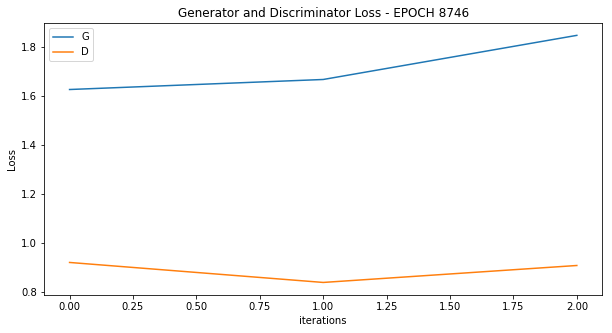

Time for epoch 8746 is 0.2848484516143799 sec


In [ ]:
%%time
BUFFER_SIZE = 2000
BATCH_SIZE = 8
ds = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(ds)
EPOCHS = 40000
print('Starting training')
train(ds, EPOCHS)

# Model Saving & Virus Images Generator

In [ ]:
#%%time
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images_256_22000.zip', mode='w')

filename = 'gen_model_256_22000.h5'
tf.keras.models.save_model(
    generator,
    filename,
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

for k in range(10):
    generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
    f = str(k)+'.png'
    img = ((generated_image[0,:,:,:]+1.)/2.).numpy()
    tf.keras.preprocessing.image.save_img(
        f,
        img,
        scale=True
    )
    z.write(f); os.remove(f)
z.close()